In [1]:
import os
import random
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm import tqdm

/opt/miniconda3/envs/courseml/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:1000: The handshake operation timed out>
  data = fetch_version_info()


In [2]:
DATA_DIR = './training/' 

IMAGE_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR = os.path.join(DATA_DIR, 'groundtruth')

# --- New settings for Patch-based Classification ---
DEVICE = 'cpu'
EPOCHS = 50
BATCH_SIZE = 64 # We can use a larger batch size now
LEARNING_RATE = 0.001
PATCH_SIZE = 16
FOREGROUND_THRESHOLD = 0.25 # From the project description

In [3]:
def get_training_augmentations():
    """
    Returns a set of heavy augmentations for the training data.
    """
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

def get_validation_augmentations():
    """Returns minimal augmentations for validation (no resizing)."""
    return A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

In [4]:
# --- Helper function to label a mask patch ---
def patch_to_label(patch, threshold):
    """
    Assigns a label (1 for road, 0 for background) to a mask patch
    based on the percentage of foreground pixels.
    """
    # Ground truth masks have values of 0 or 255.
    # We calculate the mean and normalize to a 0-1 range.
    foreground_percentage = np.mean(patch) / 255.0
    return 1 if foreground_percentage > threshold else 0

# --- New Dataset for 16x16 Patches ---
class PatchDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augmentations=None):
        self.augmentations = augmentations
        self.patches = []

        print("Creating patches... This might take a moment.")
        # Iterate through images and create patches
        for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            img_h, img_w, _ = image.shape
            
            for y in range(0, img_h, PATCH_SIZE):
                for x in range(0, img_w, PATCH_SIZE):
                    # Ensure the patch is fully within the image bounds
                    if y + PATCH_SIZE > img_h or x + PATCH_SIZE > img_w:
                        continue
                        
                    image_patch = image[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                    mask_patch = mask[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                    
                    label = patch_to_label(mask_patch, FOREGROUND_THRESHOLD)
                    
                    self.patches.append((image_patch, label))

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        image_patch, label = self.patches[idx]
        
        if self.augmentations:
            augmented = self.augmentations(image=image_patch)
            image_patch = augmented['image']
            
        # Return the patch and its label as a tensor
        return image_patch, torch.tensor([label], dtype=torch.float32)

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- New CNN Model for Patch Classification ---
class PatchClassifier(nn.Module):
    def __init__(self, in_channels=3, out_features=1):
        super(PatchClassifier, self).__init__()
        self.network = nn.Sequential(
            # Input: 3 x 16 x 16
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # -> 32 x 8 x 8
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # -> 64 x 4 x 4
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # -> 128 x 2 x 2
            
            nn.Flatten(),
            nn.Linear(128 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, out_features)
            # --- REMOVED nn.Sigmoid() from here ---
        )
        
    def forward(self, x):
        return self.network(x)

# --- New F1 Score for Classification ---
def f1_score_classification(outputs, labels, threshold=0.5):
    # Since the model now outputs logits, apply sigmoid here for evaluation
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    
    tp = (preds * labels).sum()
    fp = (preds * (1 - labels)).sum()
    fn = ((1 - preds) * labels).sum()
    
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    return f1.item()


# --- Model Setup ---
model = PatchClassifier().to(DEVICE)

In [13]:
# --- Data Splitting and DataLoader Setup ---
all_image_ids = sorted(os.listdir(IMAGE_DIR))
random.seed(42)
random.shuffle(all_image_ids)

# Split into train and validation sets (80/20)
train_size = int(0.8 * len(all_image_ids))
train_ids = all_image_ids[:train_size]
valid_ids = all_image_ids[train_size:]

# Create lists of full file paths for the datasets
train_image_paths = [os.path.join(IMAGE_DIR, img_id) for img_id in train_ids]
train_mask_paths = [os.path.join(MASK_DIR, img_id) for img_id in train_ids]

valid_image_paths = [os.path.join(IMAGE_DIR, img_id) for img_id in valid_ids]
valid_mask_paths = [os.path.join(MASK_DIR, img_id) for img_id in valid_ids]

# Create Dataset and DataLoader instances
train_dataset = PatchDataset(train_image_paths, train_mask_paths, augmentations=get_training_augmentations())
valid_dataset = PatchDataset(valid_image_paths, valid_mask_paths, augmentations=get_validation_augmentations())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nCreated {len(train_dataset)} training patches and {len(valid_dataset)} validation patches.")


# --- NEW: Handle Class Imbalance and Finalize Optimizer/Loss ---

# 1. Calculate weights for the positive class (road)
print("\nCalculating weights for class imbalance...")
num_pos = sum(1 for _, label in train_dataset if label.item() == 1)
num_neg = len(train_dataset) - num_pos
pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(DEVICE)

print(f"Dataset has {num_pos} road patches and {num_neg} background patches.")
print(f"Using a pos_weight of: {pos_weight.item():.2f}")

# 2. Define loss function with the calculated weight
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 3. Define optimizer with weight_decay to reduce overfitting
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# 4. Define a learning rate scheduler to adjust LR on plateau
# --- CORRECTED to remove the 'verbose' argument ---
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

Creating patches... This might take a moment.


100%|██████████| 80/80 [00:00<00:00, 186.49it/s]


Creating patches... This might take a moment.


100%|██████████| 20/20 [00:00<00:00, 210.96it/s]



Created 50000 training patches and 12500 validation patches.

Calculating weights for class imbalance...
Dataset has 13181 road patches and 36819 background patches.
Using a pos_weight of: 2.79


In [14]:
# --- PyTorch Training and Validation Loop ---

max_fscore = 0
best_model_path = 'best_model.pth'

for epoch in range(EPOCHS):
    print(f'\nEpoch: {epoch + 1}/{EPOCHS}')
    
    # --- Training Phase ---
    model.train()
    train_loss, train_fscore, train_correct = 0, 0, 0
    train_pbar = tqdm(train_loader, desc=f"Training", leave=False)
    
    for patches, labels in train_pbar:
        patches, labels = patches.to(DEVICE), labels.to(DEVICE)
        
        # Forward pass
        outputs = model(patches)
        loss = loss_fn(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate metrics
        train_loss += loss.item()
        f1 = f1_score_classification(outputs, labels)
        train_fscore += f1
        
        # Update progress bar
        train_pbar.set_postfix(loss=loss.item(), f1=f1)
    
    # --- Validation Phase ---
    model.eval()
    val_loss, val_fscore = 0, 0
    with torch.no_grad():
        val_pbar = tqdm(valid_loader, desc=f"Validation", leave=False)
        for patches, labels in val_pbar:
            patches, labels = patches.to(DEVICE), labels.to(DEVICE)
            
            # Forward pass
            outputs = model(patches)
            loss = loss_fn(outputs, labels)
            
            # Accumulate metrics
            val_loss += loss.item()
            f1 = f1_score_classification(outputs, labels)
            val_fscore += f1
            
            # Update progress bar
            val_pbar.set_postfix(loss=loss.item(), f1=f1)

    # --- Logging and Model Saving ---
    avg_train_loss = train_loss / len(train_loader)
    avg_train_fscore = train_fscore / len(train_loader)
    
    avg_val_loss = val_loss / len(valid_loader)
    avg_val_fscore = val_fscore / len(valid_loader)

    # --- NEW: Step the learning rate scheduler ---
    scheduler.step(avg_val_loss)
    
    print(f"Train -> Loss: {avg_train_loss:.4f}, F1-Score: {avg_train_fscore:.4f}")
    print(f"Valid -> Loss: {avg_val_loss:.4f}, F1-Score: {avg_val_fscore:.4f}")
    
    # Save the model if it has the best validation F1-score so far
    if avg_val_fscore > max_fscore:
        max_fscore = avg_val_fscore
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved! Best Validation F1-Score: {max_fscore:.4f}")


Epoch: 1/50


Train -> Loss: 0.8381, F1-Score: 0.5431
Valid -> Loss: 0.7699, F1-Score: 0.4971
Model saved! Best Validation F1-Score: 0.4971

Epoch: 2/50


Train -> Loss: 0.7191, F1-Score: 0.6333
Valid -> Loss: 0.7739, F1-Score: 0.4966

Epoch: 3/50


Train -> Loss: 0.6849, F1-Score: 0.6466
Valid -> Loss: 0.6868, F1-Score: 0.5329
Model saved! Best Validation F1-Score: 0.5329

Epoch: 4/50


Train -> Loss: 0.6649, F1-Score: 0.6587
Valid -> Loss: 0.7442, F1-Score: 0.5229

Epoch: 5/50


Train -> Loss: 0.6509, F1-Score: 0.6627
Valid -> Loss: 0.6807, F1-Score: 0.5357
Model saved! Best Validation F1-Score: 0.5357

Epoch: 6/50


Train -> Loss: 0.6378, F1-Score: 0.6661
Valid -> Loss: 0.6728, F1-Score: 0.5217

Epoch: 7/50


Train -> Loss: 0.6263, F1-Score: 0.6743
Valid -> Loss: 0.6549, F1-Score: 0.5589
Model saved! Best Validation F1-Score: 0.5589

Epoch: 8/50


Train -> Loss: 0.6144, F1-Score: 0.6787
Valid -> Loss: 0.6633, F1-Score: 0.5480

Epoch: 9/50


Train -> Loss: 0.6059, F1-Score: 0.6869
Valid -> Loss: 0.6664, F1-Score: 0.5395

Epoch: 10/50


Train -> Loss: 0.5983, F1-Score: 0.6877
Valid -> Loss: 0.6794, F1-Score: 0.5368

Epoch: 11/50


Train -> Loss: 0.5930, F1-Score: 0.6881
Valid -> Loss: 0.6703, F1-Score: 0.5418

Epoch: 12/50


Train -> Loss: 0.5864, F1-Score: 0.6955
Valid -> Loss: 0.6464, F1-Score: 0.5498

Epoch: 13/50


Train -> Loss: 0.5770, F1-Score: 0.6998
Valid -> Loss: 0.6553, F1-Score: 0.5576

Epoch: 14/50


Train -> Loss: 0.5730, F1-Score: 0.6983
Valid -> Loss: 0.6467, F1-Score: 0.5503

Epoch: 15/50


Train -> Loss: 0.5578, F1-Score: 0.7050
Valid -> Loss: 0.6402, F1-Score: 0.5611
Model saved! Best Validation F1-Score: 0.5611

Epoch: 16/50


Train -> Loss: 0.5562, F1-Score: 0.7086
Valid -> Loss: 0.6426, F1-Score: 0.5586

Epoch: 17/50


Train -> Loss: 0.5534, F1-Score: 0.7074
Valid -> Loss: 0.6399, F1-Score: 0.5554

Epoch: 18/50


Train -> Loss: 0.5475, F1-Score: 0.7118
Valid -> Loss: 0.6457, F1-Score: 0.5651
Model saved! Best Validation F1-Score: 0.5651

Epoch: 19/50


Train -> Loss: 0.5436, F1-Score: 0.7156
Valid -> Loss: 0.6503, F1-Score: 0.5434

Epoch: 20/50


Train -> Loss: 0.5422, F1-Score: 0.7163
Valid -> Loss: 0.6639, F1-Score: 0.5424

Epoch: 21/50


Train -> Loss: 0.5317, F1-Score: 0.7182
Valid -> Loss: 0.6402, F1-Score: 0.5517

Epoch: 22/50


Train -> Loss: 0.5304, F1-Score: 0.7182
Valid -> Loss: 0.6552, F1-Score: 0.5505

Epoch: 23/50


Train -> Loss: 0.5233, F1-Score: 0.7218
Valid -> Loss: 0.6531, F1-Score: 0.5617

Epoch: 24/50


Train -> Loss: 0.4770, F1-Score: 0.7436
Valid -> Loss: 0.6446, F1-Score: 0.5712
Model saved! Best Validation F1-Score: 0.5712

Epoch: 25/50


Train -> Loss: 0.4672, F1-Score: 0.7487
Valid -> Loss: 0.6503, F1-Score: 0.5692

Epoch: 26/50


Train -> Loss: 0.4649, F1-Score: 0.7490
Valid -> Loss: 0.6517, F1-Score: 0.5629

Epoch: 27/50


Train -> Loss: 0.4609, F1-Score: 0.7561
Valid -> Loss: 0.6570, F1-Score: 0.5690

Epoch: 28/50


Train -> Loss: 0.4545, F1-Score: 0.7549
Valid -> Loss: 0.6484, F1-Score: 0.5689

Epoch: 29/50


Train -> Loss: 0.4537, F1-Score: 0.7554
Valid -> Loss: 0.6556, F1-Score: 0.5736
Model saved! Best Validation F1-Score: 0.5736

Epoch: 30/50


Train -> Loss: 0.4501, F1-Score: 0.7580
Valid -> Loss: 0.6498, F1-Score: 0.5669

Epoch: 31/50


Train -> Loss: 0.4475, F1-Score: 0.7603
Valid -> Loss: 0.6497, F1-Score: 0.5682

Epoch: 32/50


Train -> Loss: 0.4498, F1-Score: 0.7573
Valid -> Loss: 0.6506, F1-Score: 0.5684

Epoch: 33/50


Train -> Loss: 0.4465, F1-Score: 0.7582
Valid -> Loss: 0.6519, F1-Score: 0.5672

Epoch: 34/50


Train -> Loss: 0.4496, F1-Score: 0.7590
Valid -> Loss: 0.6511, F1-Score: 0.5704

Epoch: 35/50


Train -> Loss: 0.4442, F1-Score: 0.7621
Valid -> Loss: 0.6534, F1-Score: 0.5688

Epoch: 36/50


Train -> Loss: 0.4469, F1-Score: 0.7599
Valid -> Loss: 0.6526, F1-Score: 0.5692

Epoch: 37/50


Train -> Loss: 0.4414, F1-Score: 0.7610
Valid -> Loss: 0.6520, F1-Score: 0.5696

Epoch: 38/50


Train -> Loss: 0.4449, F1-Score: 0.7581
Valid -> Loss: 0.6523, F1-Score: 0.5694

Epoch: 39/50


Train -> Loss: 0.4495, F1-Score: 0.7592
Valid -> Loss: 0.6525, F1-Score: 0.5681

Epoch: 40/50


Train -> Loss: 0.4476, F1-Score: 0.7590
Valid -> Loss: 0.6520, F1-Score: 0.5684

Epoch: 41/50


Train -> Loss: 0.4482, F1-Score: 0.7580
Valid -> Loss: 0.6522, F1-Score: 0.5684

Epoch: 42/50


Train -> Loss: 0.4464, F1-Score: 0.7611
Valid -> Loss: 0.6521, F1-Score: 0.5684

Epoch: 43/50


Train -> Loss: 0.4423, F1-Score: 0.7615
Valid -> Loss: 0.6521, F1-Score: 0.5681

Epoch: 44/50


Train -> Loss: 0.4447, F1-Score: 0.7592
Valid -> Loss: 0.6521, F1-Score: 0.5684

Epoch: 45/50


Train -> Loss: 0.4444, F1-Score: 0.7612
Valid -> Loss: 0.6521, F1-Score: 0.5681

Epoch: 46/50


Train -> Loss: 0.4413, F1-Score: 0.7615
Valid -> Loss: 0.6520, F1-Score: 0.5681

Epoch: 47/50


Train -> Loss: 0.4430, F1-Score: 0.7616
Valid -> Loss: 0.6520, F1-Score: 0.5682

Epoch: 48/50


Train -> Loss: 0.4461, F1-Score: 0.7600
Valid -> Loss: 0.6520, F1-Score: 0.5682

Epoch: 49/50


Train -> Loss: 0.4463, F1-Score: 0.7614
Valid -> Loss: 0.6520, F1-Score: 0.5682

Epoch: 50/50


Train -> Loss: 0.4415, F1-Score: 0.7628
Valid -> Loss: 0.6520, F1-Score: 0.5682


In [15]:
# --- Final Prediction and Submission ---
import re

TEST_IMAGE_DIR = './test_set_images/'
SUBMISSION_FILENAME = 'submission.csv'

# Load the best trained model
print("\nLoading best patch classifier model for prediction...")
best_model = PatchClassifier().to(DEVICE)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()
print("Model loaded.")

# Get augmentations for test data
test_augmentations = get_validation_augmentations()

# Collect all test image file paths
test_image_paths = []
for root, _, files in os.walk(TEST_IMAGE_DIR):
    for file in files:
        if file.endswith(".png"):
            test_image_paths.append(os.path.join(root, file))
test_image_paths.sort()

print(f"Found {len(test_image_paths)} test images. Generating submission file...")
with open(SUBMISSION_FILENAME, "w") as f:
    f.write("id,prediction\n")
    
    for img_path in tqdm(test_image_paths):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        img_h, img_w, _ = image.shape
        img_id_str = os.path.basename(img_path)
        img_number = int(re.search(r"(\d+)", img_id_str).group(1))
        
        for y in range(0, img_h, PATCH_SIZE):
            for x in range(0, img_w, PATCH_SIZE):
                if y + PATCH_SIZE > img_h or x + PATCH_SIZE > img_w:
                    continue
                
                image_patch = image[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                
                # Apply transformations
                augmented = test_augmentations(image=image_patch)
                input_tensor = augmented['image'].unsqueeze(0).to(DEVICE)

                # Predict with the model
                with torch.no_grad():
                    output = best_model(input_tensor)
                    prediction = 1 if output.item() > 0.5 else 0
                
                # Write to submission file
                submission_id = "{:03d}_{}_{}".format(img_number, x, y)
                f.write(f"{submission_id},{prediction}\n")

print(f"\n--- Submission file '{SUBMISSION_FILENAME}' created successfully! ---")


Loading best patch classifier model for prediction...
Model loaded.
Found 50 test images. Generating submission file...


100%|██████████| 50/50 [00:14<00:00,  3.47it/s]


--- Submission file 'submission.csv' created successfully! ---


Loading the best model for visualization...
Model loaded.

Displaying results for 3 random validation images...


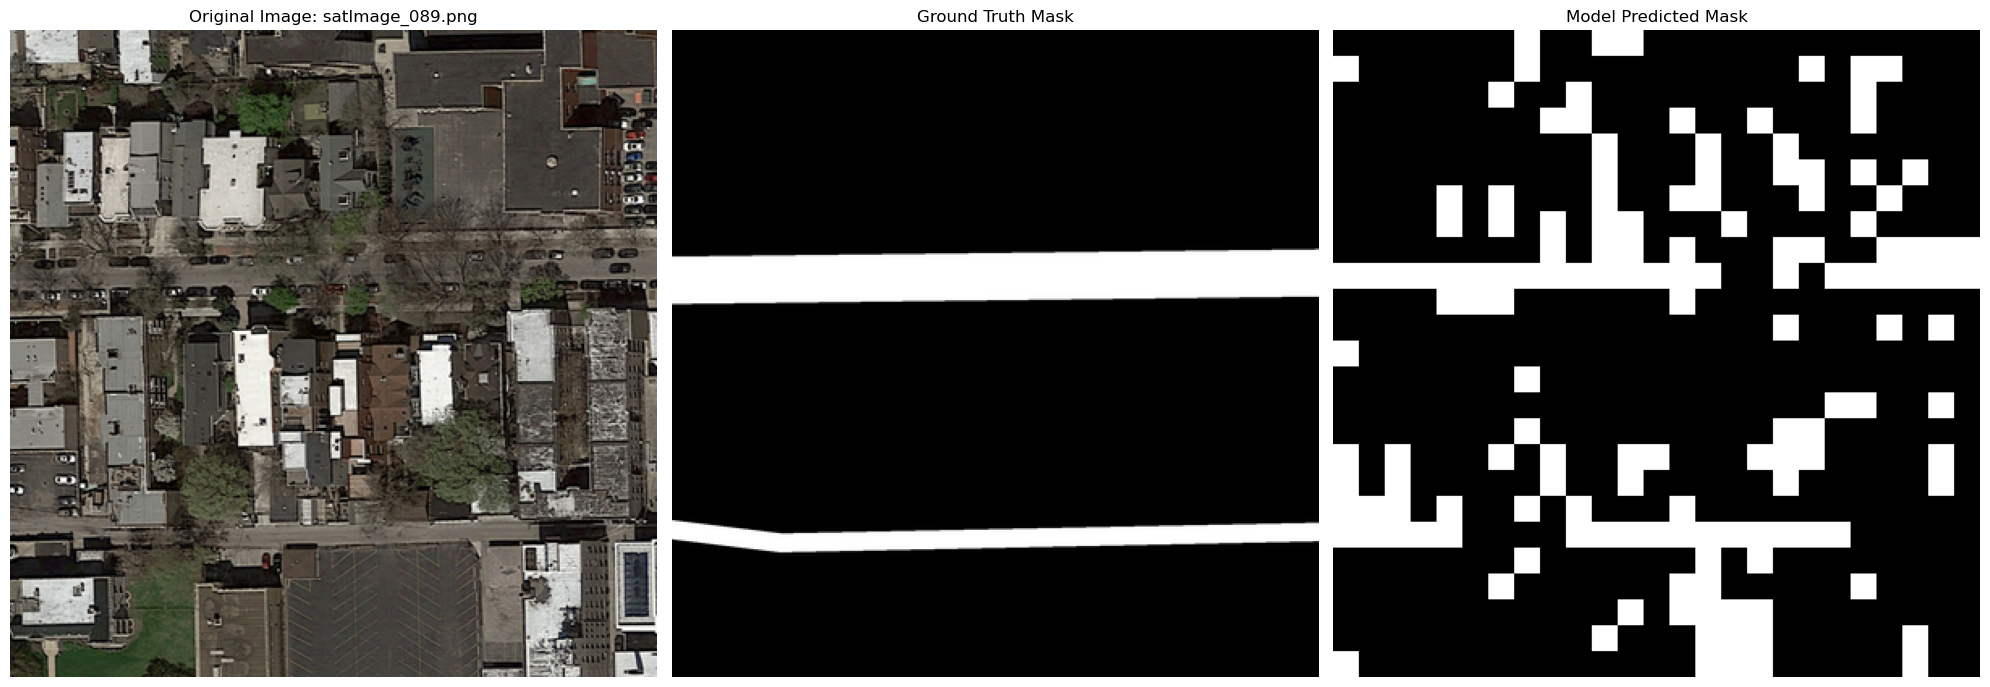

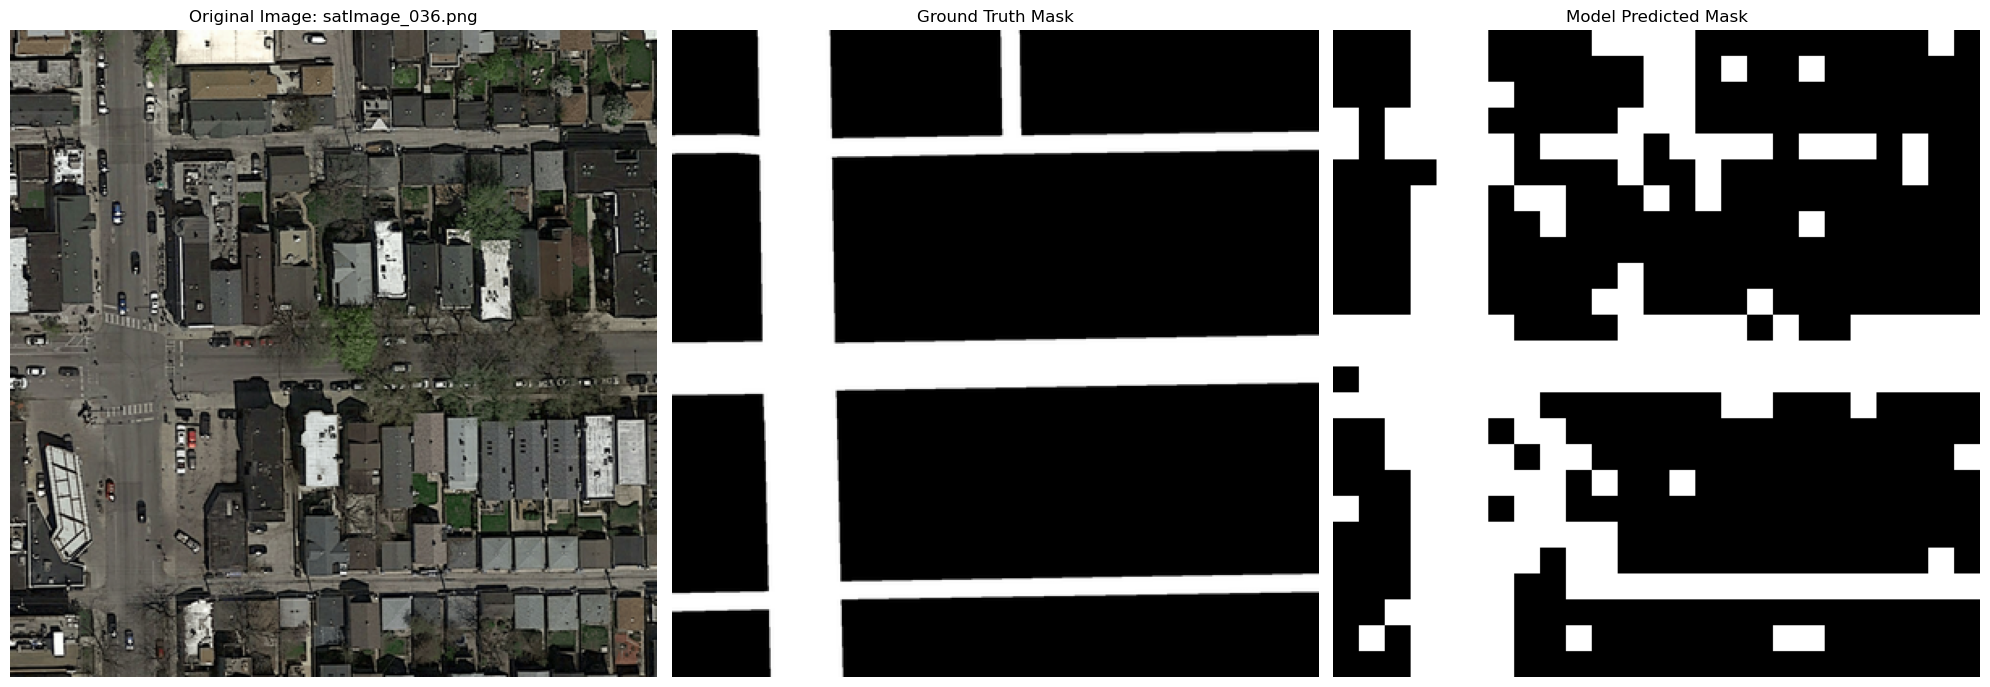

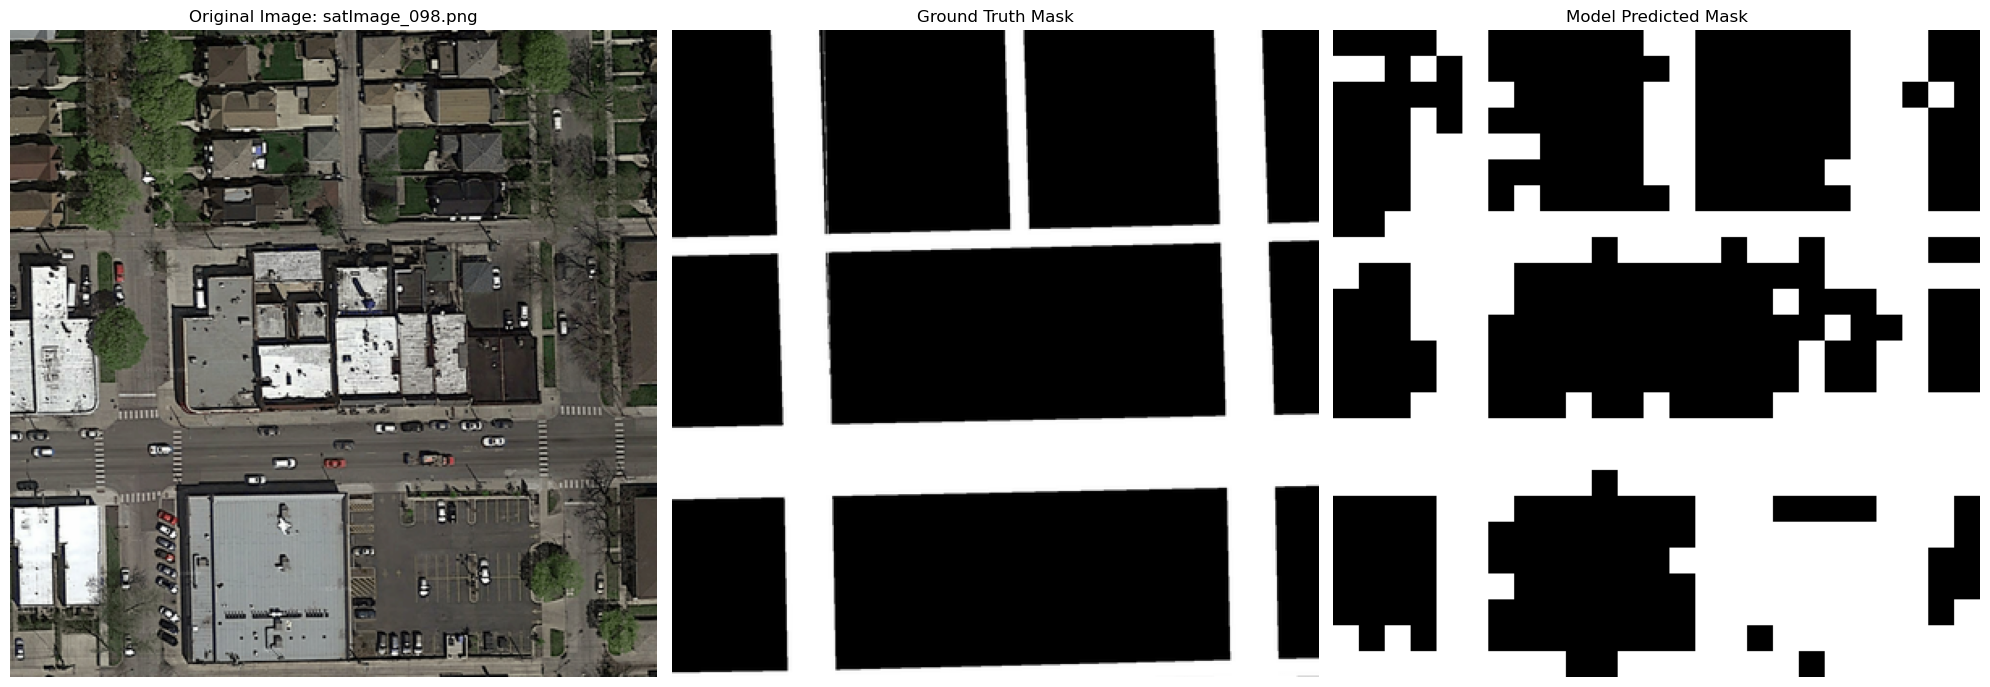

In [16]:
# --- Visualization Cell ---

# 1. Load the best model saved during training
print("Loading the best model for visualization...")
# Ensure the model architecture is the same as the one you trained
vis_model = PatchClassifier().to(DEVICE) 
vis_model.load_state_dict(torch.load(best_model_path))
vis_model.eval() # Set the model to evaluation mode
print("Model loaded.")

# Get the same augmentations used for validation
vis_augmentations = get_validation_augmentations()

# 2. Helper function to predict a full mask for a single image
def predict_full_mask(image_path, model, augmentations, device, patch_size):
    """
    Takes an image path and a trained model, and returns the
    full predicted mask as a NumPy array.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape
    
    # Create a blank mask to store patch predictions
    predicted_mask = np.zeros((img_h, img_w), dtype=np.uint8)
    
    # Iterate over the image in patches
    for y in range(0, img_h, patch_size):
        for x in range(0, img_w, patch_size):
            if y + patch_size > img_h or x + patch_size > img_w:
                continue
            
            image_patch = image[y:y+patch_size, x:x+patch_size]
            
            # Apply transformations
            augmented = augmentations(image=image_patch)
            input_tensor = augmented['image'].unsqueeze(0).to(device)
            
            # Predict with the model
            with torch.no_grad():
                output = model(input_tensor)
                # Apply sigmoid to the raw logits output to get a probability
                prob = torch.sigmoid(output)
                # Classify as 1 (road) if probability is > 0.5
                prediction = 1 if prob.item() > 0.5 else 0
            
            # Fill the corresponding patch in the predicted mask with the result
            predicted_mask[y:y+patch_size, x:x+patch_size] = prediction * 255 # Use 255 for white
            
    return predicted_mask

# 3. Visualize a few images from the validation set
NUM_IMAGES_TO_SHOW = 3
print(f"\nDisplaying results for {NUM_IMAGES_TO_SHOW} random validation images...")

for i in range(NUM_IMAGES_TO_SHOW):
    # Get a random image from the validation set
    idx = np.random.randint(0, len(valid_image_paths))
    img_path = valid_image_paths[idx]
    mask_path = valid_mask_paths[idx]
    
    # Load original image and ground truth mask
    original_image = cv2.imread(img_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Generate the predicted mask using the function above
    predicted_mask = predict_full_mask(img_path, vis_model, vis_augmentations, DEVICE, PATCH_SIZE)
    
    # Plotting the three images side-by-side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    
    ax1.imshow(original_image)
    ax1.set_title(f'Original Image: {os.path.basename(img_path)}')
    ax1.axis('off')
    
    ax2.imshow(ground_truth_mask, cmap='gray')
    ax2.set_title('Ground Truth Mask')
    ax2.axis('off')
    
    ax3.imshow(predicted_mask, cmap='gray')
    ax3.set_title('Model Predicted Mask')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()